In [1]:
# Question Type Numbers in Evaluation Set:
#{'color_room': 1335, 'color': 345, 'location': 270} total = 1950
# validation answer vocab: 35 words (including unk)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, confusion_matrix, f1_score
import json
import matplotlib.ticker as ticker
from collections import Counter

In [3]:
#Validation Set
with open('/home/yasmeen/Desktop/val.json') as json_file:
    val = json.load(json_file)
episodes = val['episodes']

In [4]:
def unique(sequence):
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

In [5]:
counts = Counter(val['answer_vocab']['word_list'])
new_list = sorted(val['answer_vocab']['word_list'], key=lambda x: -counts[x])
answer_vocab = unique(new_list)
print(answer_vocab)

['brown', 'white', 'silver', 'black', 'off-white', 'tan', 'kitchen', 'grey', 'green', 'blue', 'bedroom', 'living room', 'bathroom', 'slate grey', 'laundry room', 'olive green', 'family room', 'closet', 'lounge', 'red', 'yellow green', 'spa', 'purple', 'red brown', 'light blue', 'tv room', 'hallway', 'dining room', 'purple pink', 'office', 'yellow pink', 'orange yellow', 'foyer', 'yellow', '<unk>']


In [6]:
# making gt episode ids consecutive
i = 0
for item in episodes:
    item['episode_id'] = i
    i += 1

In [7]:
# List to DataFrame
ans = pd.DataFrame()
print(len(episodes))
for item in episodes:
    ans = ans.append({'episode_id': int(item['episode_id']), 'question': item['question']['question_text'], 'prediction': item['question']['answer_text'], 'question_type': item['question']['question_type']}, ignore_index=True)

1950


In [8]:
#Combine wrong answers w/ questions model got correct
def constr_answers(file):
    wrong_ans = pd.read_csv(file, header=0)
    df = ans[ans['episode_id'].isin(wrong_ans['episode_id']) == False]
    model_ans = wrong_ans.append(df)
    return model_ans

In [9]:
wrong_file = "/home/yasmeen/Desktop/wrong_answers/wrong_answers_boosted/wrong_answers15.csv"
model_ans = constr_answers(wrong_file)
print(model_ans.sort_values(by='episode_id'))
print(cohen_kappa_score(ans['prediction'], model_ans['prediction']))
print(cohen_kappa_score(ans.loc[ans['question_type'] == 'color_room']['prediction'], model_ans.loc[model_ans['question_type'] == 'color_room']['prediction']))

                                       question question_type ground truth  \
0      what color is the picture in the closet?    color_room          NaN   
90    what color is the picture in the closet ?    color_room        brown   
81    what color is the picture in the closet ?    color_room        brown   
95    what color is the picture in the closet ?    color_room        brown   
15    what color is the picture in the closet ?    color_room        brown   
...                                         ...           ...          ...   
940           what room is the bed located in ?      location      bedroom   
1064     what room is the tv stand located in ?      location  family room   
848      what room is the tv stand located in ?      location  family room   
1948           what room is the bed located in?      location          NaN   
891           what room is the bed located in ?      location      bedroom   

      ground truth position   prediction  episode_id  
0       

In [10]:
#produce cohen kappa scores as a dictionary
def cohen_kappa_dict(ground_truth_answers, model_answers):
    return {'total': cohen_kappa_score(ground_truth_answers['prediction'], model_answers['prediction'], labels = answer_vocab),
    'color_room': cohen_kappa_score(ground_truth_answers.loc[ground_truth_answers['question_type'] == 'color_room']['prediction'], model_answers.loc[model_answers['question_type'] == 'color_room']['prediction'], labels = answer_vocab),
    'color': cohen_kappa_score(ground_truth_answers.loc[ground_truth_answers['question_type'] == 'color']['prediction'], model_answers.loc[model_answers['question_type'] == 'color']['prediction'], labels = answer_vocab),
    'location': cohen_kappa_score(ground_truth_answers.loc[ground_truth_answers['question_type'] == 'location']['prediction'], model_answers.loc[model_answers['question_type'] == 'location']['prediction'], labels = answer_vocab)}
#total


In [11]:
def produce_kappa_frame(experiment):
    kappa_frame = pd.DataFrame()
    for c in range(0, 50):
        wrong_file = "/home/yasmeen/Desktop/wrong_answers/{}/wrong_answers{}.csv".format(experiment, c)
        kappa_frame = kappa_frame.append(cohen_kappa_dict(ans, constr_answers(wrong_file)), ignore_index=True)
    return kappa_frame

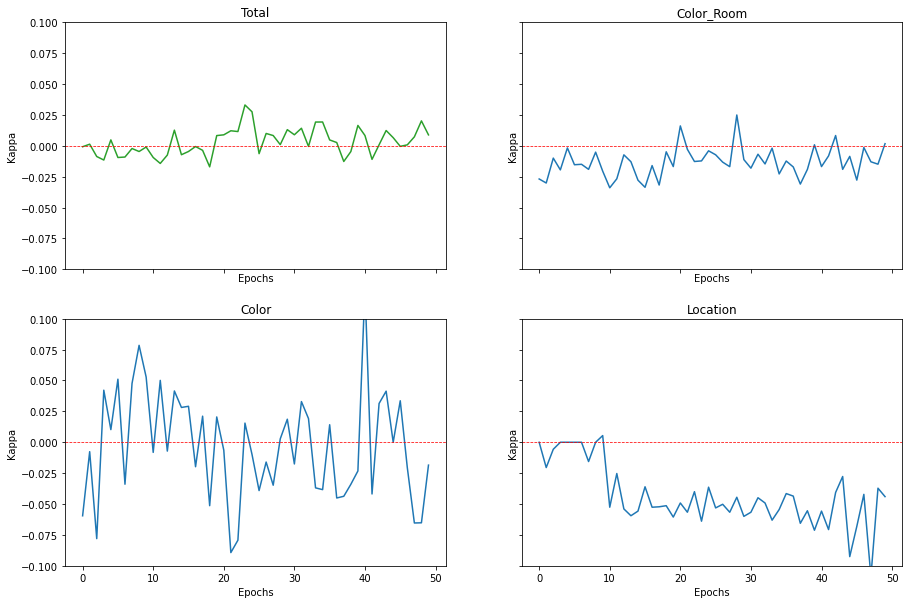

color         40
color_room    28
location       9
total         23
dtype: int64


In [12]:
def produce_kappa_graphs(experiment):
    kappa_frame = produce_kappa_frame(experiment)
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
    fig.set_size_inches(15, 10, forward=True)
    axs[0,0].plot(kappa_frame['total'], 'tab:green')
    axs[0, 0].set_title('Total')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Kappa')
    axs[0,1].plot(kappa_frame['color_room'])
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Kappa')
    axs[0, 1].set_title('Color_Room')
    axs[1,0].plot(kappa_frame['color'])
    axs[1, 0].set_title('Color')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Kappa')
    axs[1,1].plot(kappa_frame['location'])
    axs[1, 1].set_title('Location')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Kappa')
    
    for c in axs:
        for ax in c:
            ax.axhline(y=0, color='r', linewidth=0.75, linestyle='dashed')


    plt.ylim(-.1, .1)
    fig_path = '/home/yasmeen/Desktop/thesisproj/thesis/figure/wrong_answers/' + experiment + '_kappa'
    plt.savefig(fig_path)
    plt.show()
    
    best_total_index = kappa_frame.idxmax()
    print(best_total_index)
    
produce_kappa_graphs('baseline_wrong_answer')

In [13]:
def plot_confusion_matrix(experiment, epoch, cmap=plt.cm.Purples, labels=None):
    labels=answer_vocab
    cm = confusion_matrix(ans['prediction'], constr_answers("/home/yasmeen/Desktop/wrong_answers/{}/wrong_answers{}.csv".format(experiment, epoch))['prediction'], labels=answer_vocab)
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 10, forward=True)
    height, width = cm.shape

    cax = ax.matshow(cm,cmap=cmap)
    fig.colorbar(cax)
    if labels:
        ax.tick_params('x', labelrotation=90)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.xlabel('Predicted')
    plt.ylabel('True')
    fig_path = '/home/yasmeen/Desktop/thesisproj/thesis/figure/wrong_answers/' + experiment + '_confusion'
    plt.savefig(fig_path)


/home/yasmeen/anaconda3/envs/habitatenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/home/yasmeen/anaconda3/envs/habitatenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


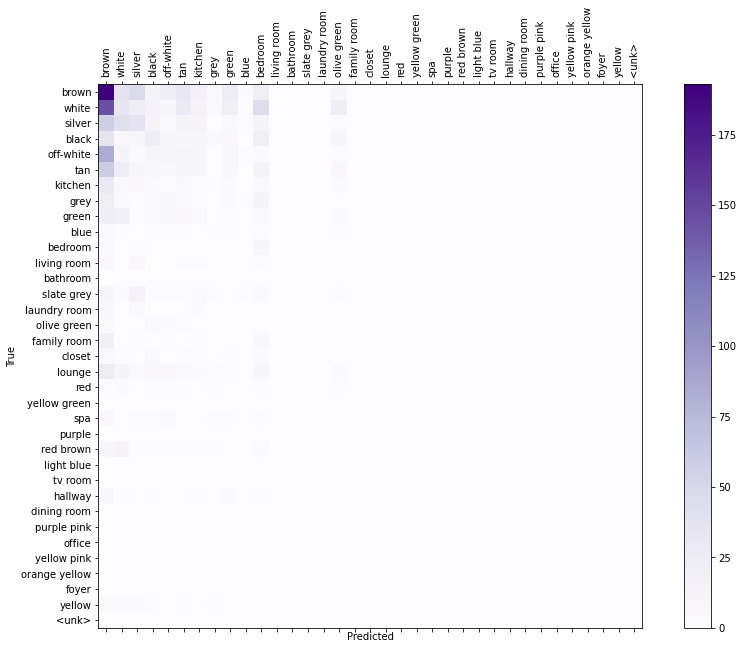

In [14]:
plot_confusion_matrix('baseline_wrong_answer', 23)

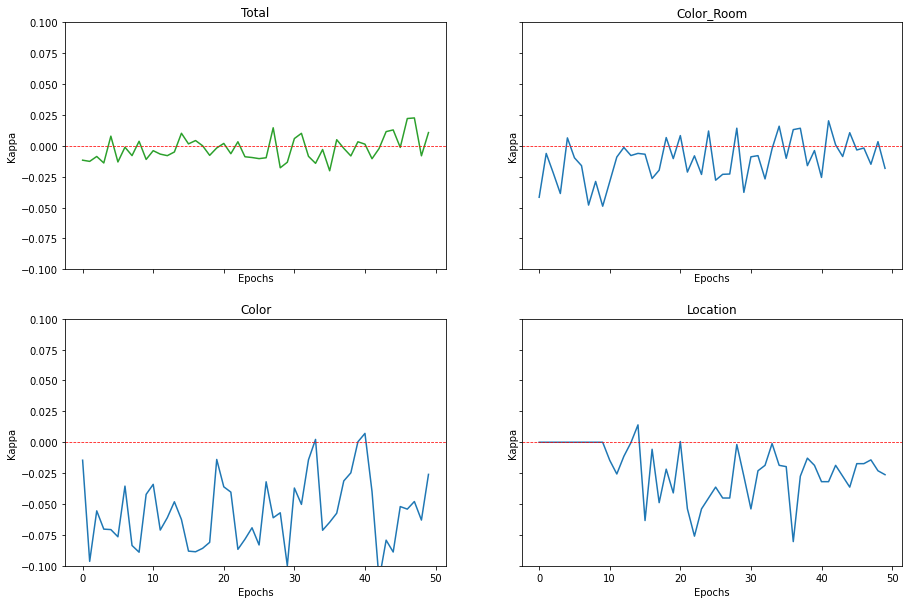

color         40
color_room    41
location      14
total         47
dtype: int64


In [15]:
produce_kappa_graphs('wrong_answers_category')

/home/yasmeen/anaconda3/envs/habitatenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/home/yasmeen/anaconda3/envs/habitatenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


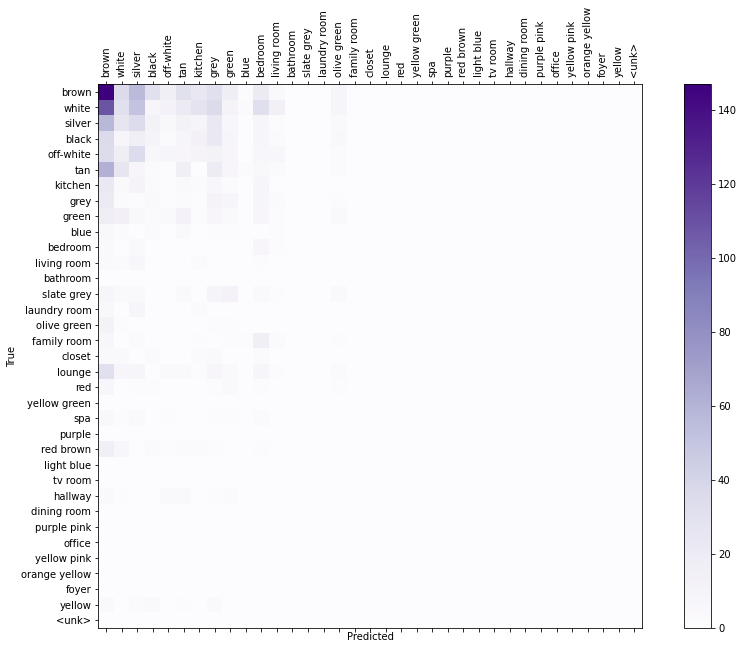

In [16]:
plot_confusion_matrix('wrong_answers_category', 47)

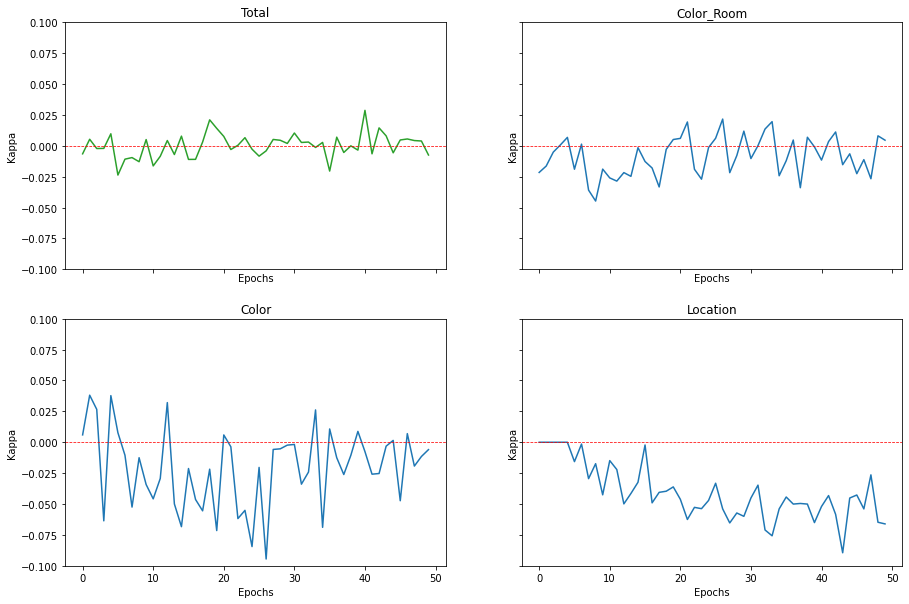

color          1
color_room    26
location       1
total         40
dtype: int64


In [17]:
produce_kappa_graphs('wrong_answers_look_around')

/home/yasmeen/anaconda3/envs/habitatenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/home/yasmeen/anaconda3/envs/habitatenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


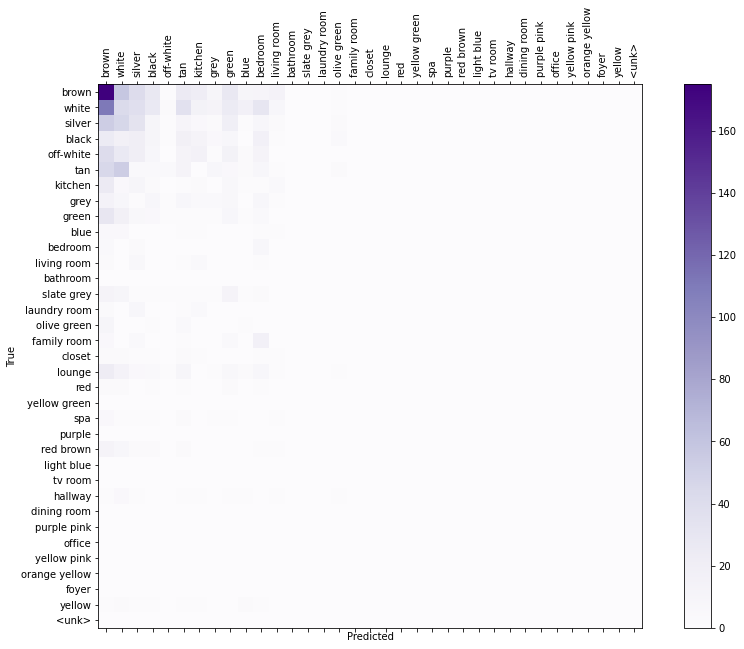

In [18]:
plot_confusion_matrix('wrong_answers_look_around', 40)

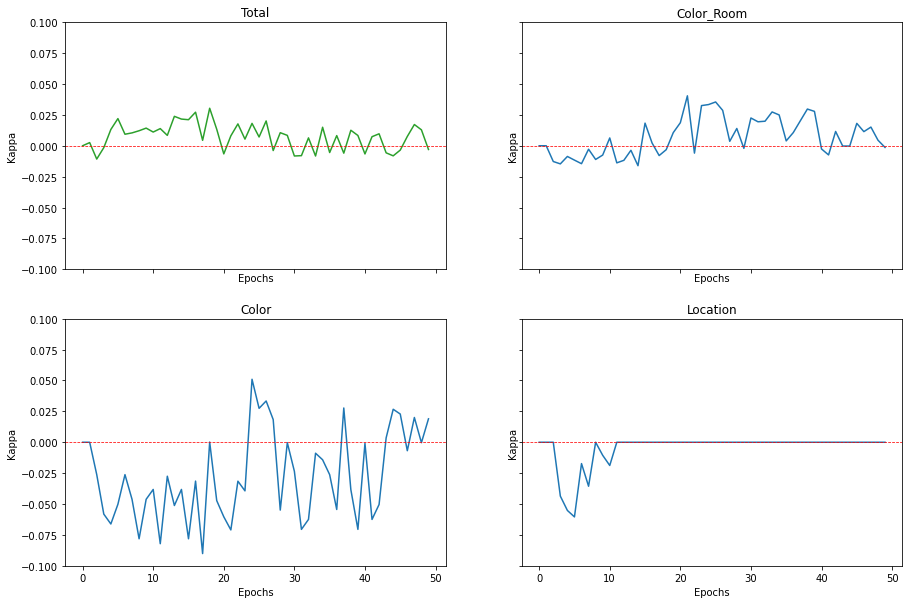

color         24
color_room    21
location      25
total         18
dtype: int64


In [19]:
produce_kappa_graphs('wrong_answers_fully_blind')

/home/yasmeen/anaconda3/envs/habitatenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/home/yasmeen/anaconda3/envs/habitatenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


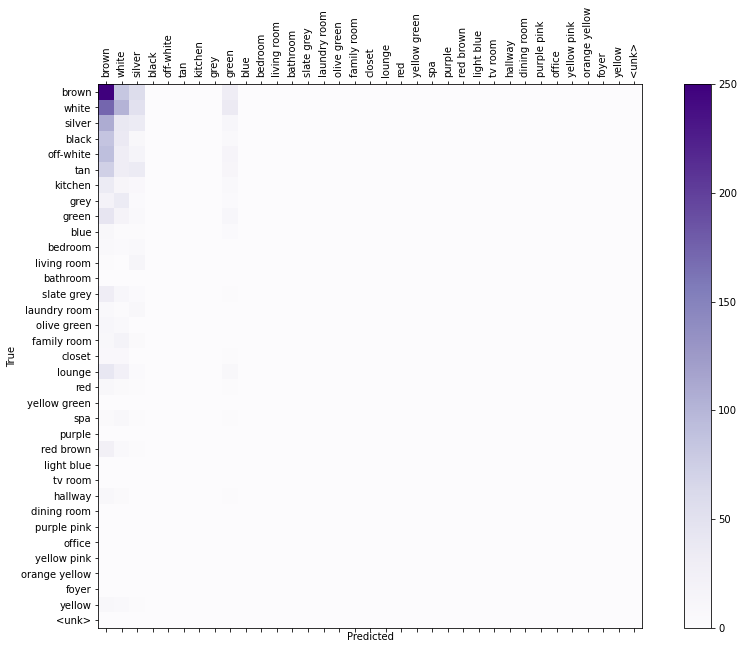

In [20]:
plot_confusion_matrix('wrong_answers_fully_blind', 18)

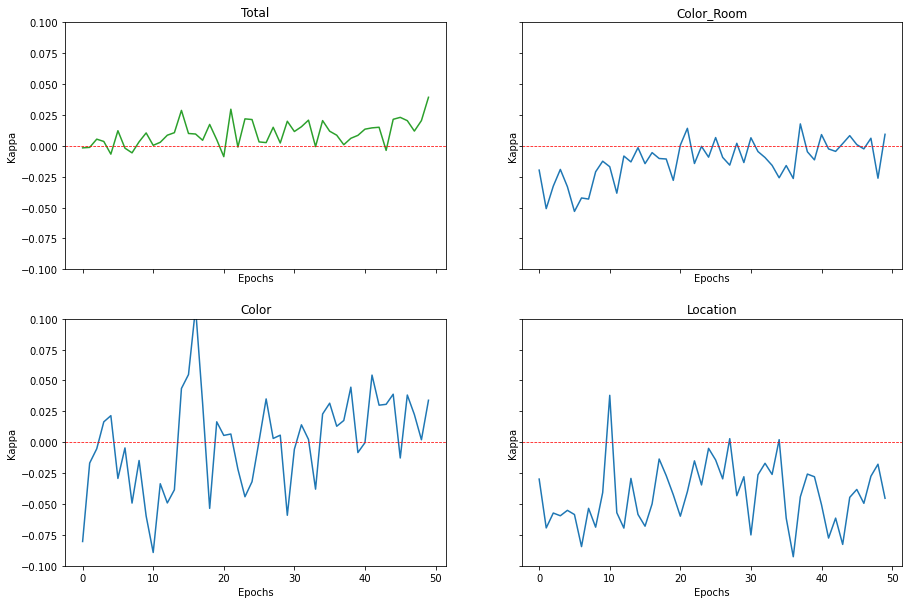

color         16
color_room    37
location      10
total         49
dtype: int64


In [21]:
produce_kappa_graphs('wrong_answers_boosted')

/home/yasmeen/anaconda3/envs/habitatenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/home/yasmeen/anaconda3/envs/habitatenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


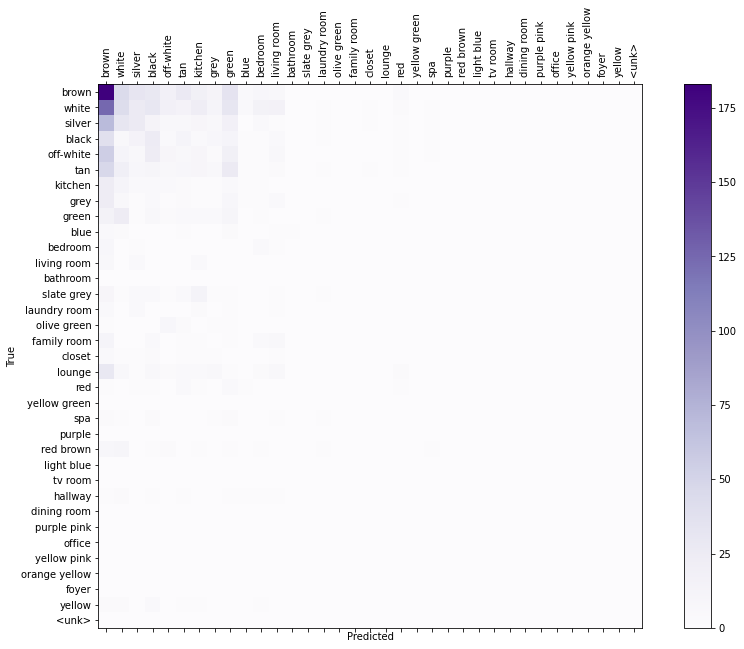

In [22]:
plot_confusion_matrix('wrong_answers_boosted', 49)

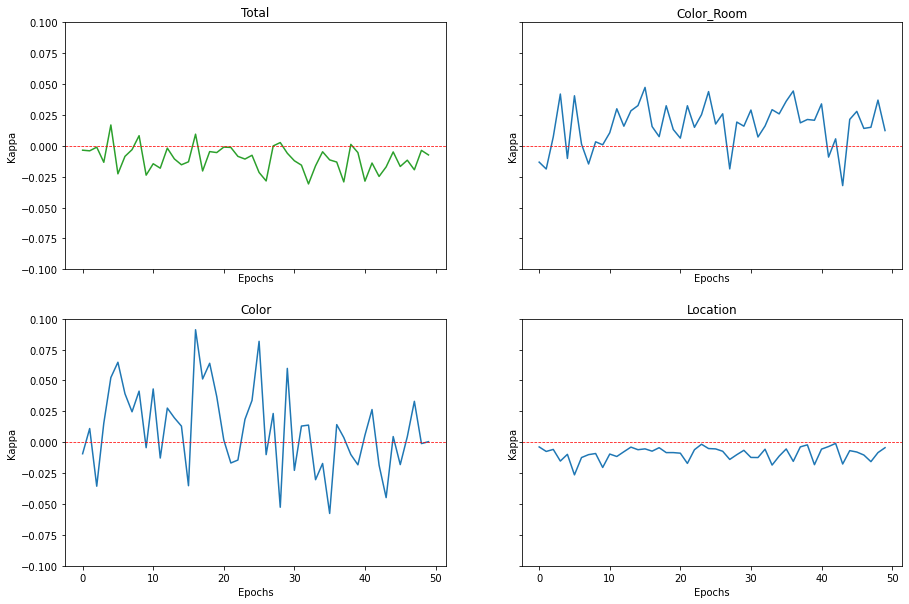

color         16
color_room    15
location      42
total          4
dtype: int64


In [23]:
produce_kappa_graphs('wrong_answers_frcnn_feats')

/home/yasmeen/anaconda3/envs/habitatenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/home/yasmeen/anaconda3/envs/habitatenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


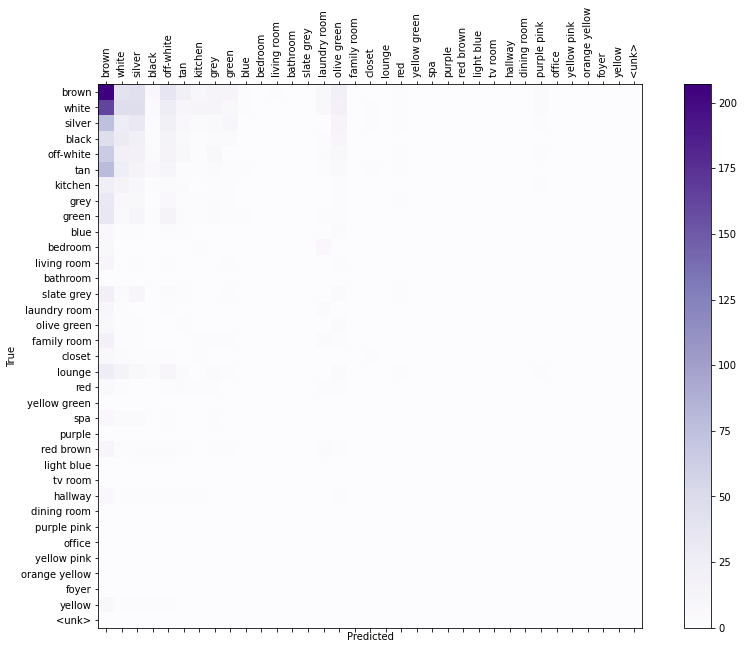

In [24]:
plot_confusion_matrix('wrong_answers_frcnn_feats', 4)

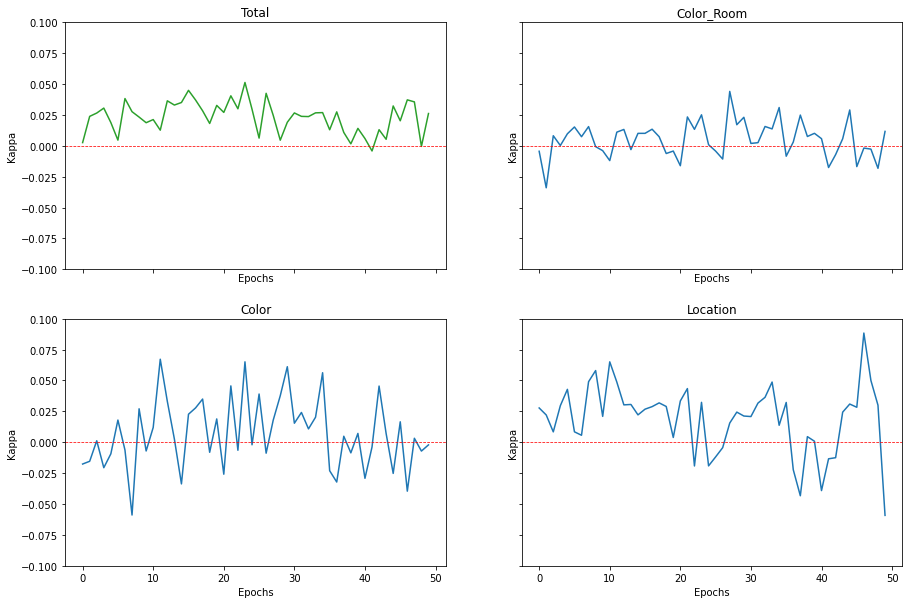

color         11
color_room    27
location      46
total         23
dtype: int64


In [25]:
produce_kappa_graphs('wrong_answers_frcnn_feats_v2')

/home/yasmeen/anaconda3/envs/habitatenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/home/yasmeen/anaconda3/envs/habitatenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


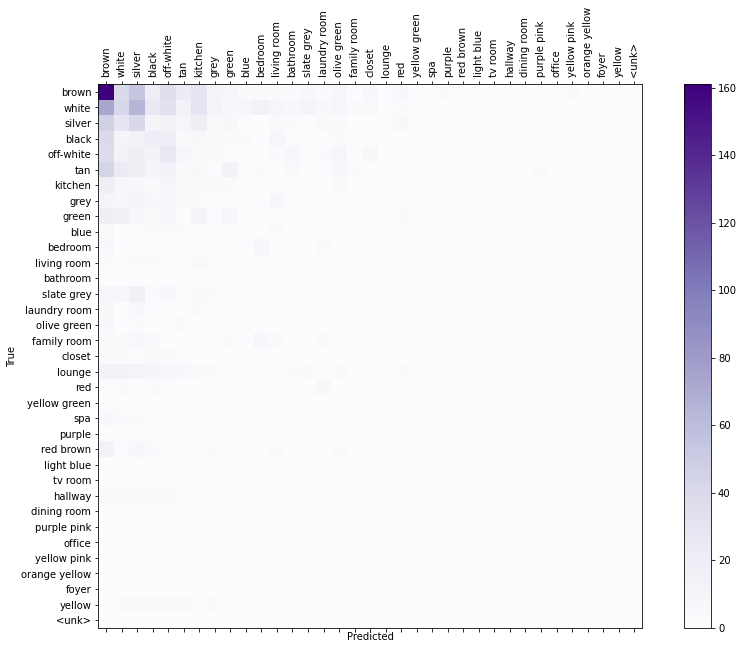

In [26]:
plot_confusion_matrix('wrong_answers_frcnn_feats_v2', 23)

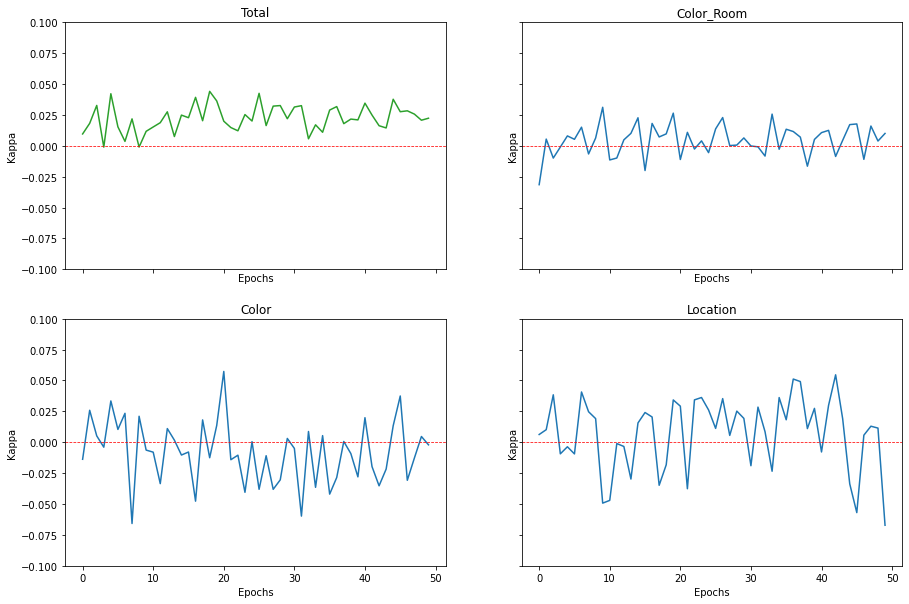

color         20
color_room     9
location      42
total         18
dtype: int64


In [27]:
produce_kappa_graphs('wrong_answers_pooling')

/home/yasmeen/anaconda3/envs/habitatenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/home/yasmeen/anaconda3/envs/habitatenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


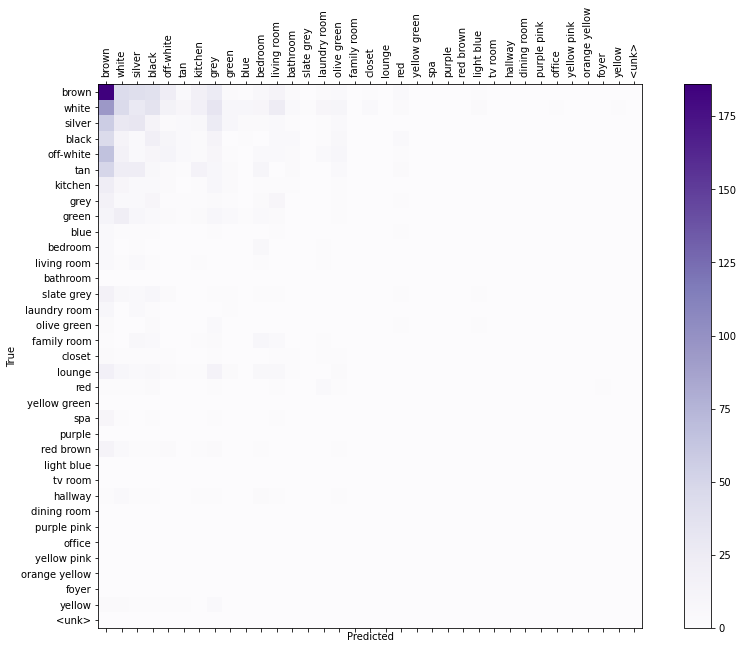

In [29]:
plot_confusion_matrix('wrong_answers_pooling', 18)